In [1]:
!pip install stable-baselines3[extra]

In [3]:
!pip install sb3-contrib

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DDPG, SAC, TD3, A2C,DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces, Env
from sb3_contrib import TRPO
# Load and preprocess data
file_path = '/content/YKOELH73.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['AAPL']] 

In [5]:
# Create a custom trading environment
class TradingEnv(Env):
    def __init__(self, data, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.current_step = 0
        self.holdings = 0
        self.reward = 0

        # Define action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32
        )

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.current_step = 0
        self.reward = 0
        return self._get_obs()

    def step(self, action):
        current_price = self.data.iloc[self.current_step]

        # Map continuous actions to discrete actions
        if action[0] < -0.5:  # Sell
            action = 0
        elif action[0] > 0.5:  # Buy
            action = 2
        else:  # Hold
            action = 1

        if action == 0:  # Sell
            self.balance += self.holdings * current_price
            self.holdings = 0
        elif action == 2:  # Buy
            quantity = self.balance // current_price
            self.holdings += quantity
            self.balance -= quantity * current_price

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_price = self.data.iloc[self.current_step] if not done else 0
        self.reward = self.balance + self.holdings * next_price

        return self._get_obs(), self.reward, done, {}


    def _get_obs(self):
        return np.array([self.data.iloc[self.current_step]]).astype(np.float32)

In [6]:
!pip install shimmy[gym]

In [8]:
# Split data into training and testing
train_data = data[:int(len(data) * 0.8)]['AAPL']
test_data = data[int(len(data) * 0.8):]['AAPL']

# Initialize environment
train_env = DummyVecEnv([lambda: TradingEnv(train_data)])
test_env = DummyVecEnv([lambda: TradingEnv(test_data)])

# Define and train models
algorithms = {
    "PPO": PPO("MlpPolicy", train_env, verbose=1),
    "A2C": A2C("MlpPolicy", train_env, verbose=1),
    "SAC": SAC("MlpPolicy", train_env, verbose=1),
    "TD3": TD3("MlpPolicy", train_env, verbose=1),
    "A2C": A2C("MlpPolicy", train_env, verbose=1),
    #"DQN": DQN("MlpPolicy", train_env, verbose=1),
    "DDPG": DDPG("MlpPolicy", train_env, verbose=1),
    "TRPO": TRPO("MlpPolicy", train_env, verbose=1)
}

trained_models = {}
for name, model in algorithms.items():
    print(f"Training {name}...")
    model.learn(total_timesteps=10000)
    trained_models[name] = model

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Using cpu device
Training PPO...
-----------------------------
| time/              |      |
|    fps             | 383  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 444           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.7548242e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | -3.58e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.45e+10      |
|    n_updates            | 10         

In [9]:
# Evaluate models
def evaluate_model(model, env):
    initial_balance = env.envs[0].initial_balance
    obs = env.reset()
    total_rewards = []

    for _ in range(len(test_data)):
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        total_rewards.append(reward)
        if done:
            break

    # Calculate final portfolio value
    final_balance = env.envs[0].balance + env.envs[0].holdings * test_data.iloc[env.envs[0].current_step]
    accuracy = (final_balance / initial_balance) * 100  # Convert to percentage
    return accuracy

accuracies = {}
for name, model in trained_models.items():
    print(f"Evaluating {name}...")
    accuracies[name] = evaluate_model(model, test_env)

# Print accuracies
for name, acc in accuracies.items():
    print(f"{name}: {acc:.2f}%")

Evaluating PPO...
Evaluating A2C...
Evaluating SAC...
Evaluating TD3...
Evaluating DDPG...
Evaluating TRPO...
PPO: 100.00%
A2C: 100.00%
SAC: 100.00%
TD3: 100.00%
DDPG: 100.00%
TRPO: 100.00%


<ipython-input-10-05907589285d>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_signals = [test_data[i] if a > 0.5 else None for i, a in enumerate(actions)]
<ipython-input-10-05907589285d>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_signals = [test_data[i] if a < -0.5 else None for i, a in enumerate(actions)]
<ipython-input-10-05907589285d>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_signals = [test_data[i

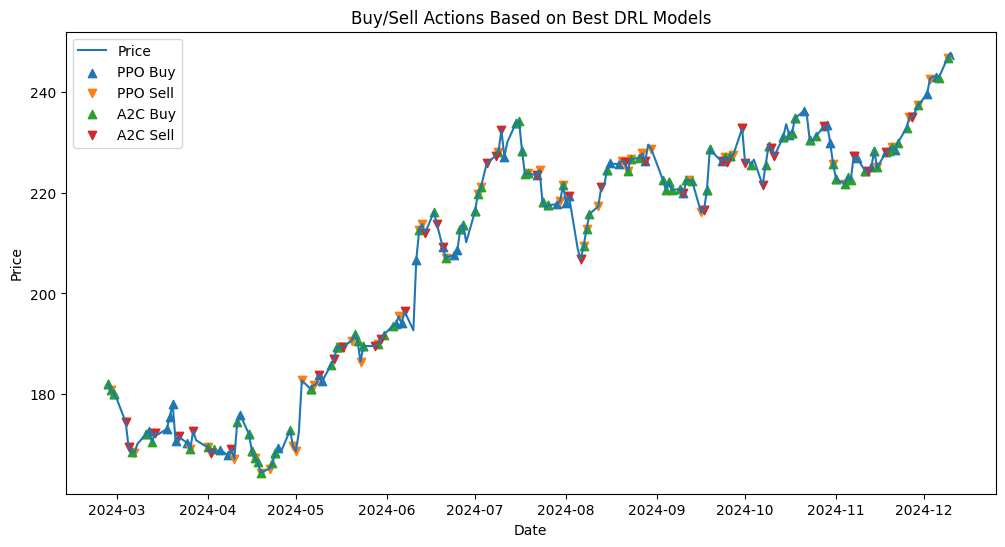

In [10]:
best_algorithms = sorted(accuracies, key=accuracies.get, reverse=True)[:2]
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Price')

for name in best_algorithms:
    model = trained_models[name]
    obs = test_env.reset()
    actions = []
    for _ in range(len(test_data)):
        action, _ = model.predict(obs)
        obs, _, done, _ = test_env.step(action)
        actions.append(action[0])
        if done:
            break

    # Create buy and sell signals with corresponding indices
    buy_signals = [test_data[i] if a > 0.5 else None for i, a in enumerate(actions)]
    sell_signals = [test_data[i] if a < -0.5 else None for i, a in enumerate(actions)]

    # Get indices where buy/sell signals are not None
    buy_indices = [i for i, val in enumerate(buy_signals) if val is not None]
    sell_indices = [i for i, val in enumerate(sell_signals) if val is not None]

    # Scatter plot using the filtered indices
    plt.scatter(test_data.index[buy_indices], [buy_signals[i] for i in buy_indices], label=f'{name} Buy', marker='^')
    plt.scatter(test_data.index[sell_indices], [sell_signals[i] for i in sell_indices], label=f'{name} Sell', marker='v')

plt.title('Buy/Sell Actions Based on Best DRL Models')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()